In [11]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV
import sklearn.tree as tree
import pandas as pd
import numpy as np

## Load the dataset

In [3]:
adult = fetch_ucirepo(id=2)
X_original = adult.data.features
y_original = adult.data.targets
print(X_original)
print(y_original)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

## Part 1: age, hours-per-week, and income

First, we need to extract age and work hours.

In [4]:
X_age = np.array(X_original)[:20000,0]
X_wh = np.array(X_original)[:20000,12]
X = np.column_stack((X_age, X_wh))
print(X)
y = np.array(y_original)[:20000]
y_cleaned = np.array([label[0].replace('.', '') for label in y])
encoder = LabelEncoder()
y = encoder.fit_transform(y_cleaned)
print(y)

[[39 40]
 [50 13]
 [38 40]
 ...
 [72 99]
 [54 44]
 [30 40]]
[0 0 0 ... 0 1 1]


In [5]:
X = pd.DataFrame(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = 2*y - 1
print(X_scaled)
print(y)

[[ 0.02961142 -0.03230868]
 [ 0.83476689 -2.23128626]
 [-0.04358453 -0.03230868]
 ...
 [ 2.44507783  4.77286455]
 [ 1.1275507   0.29346577]
 [-0.62915214 -0.03230868]]
[-1 -1 -1 ... -1  1  1]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### Logistic Regression

In [179]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000],
    'eta0': [0.01, 0.1, 0.001],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(SGDClassifier(loss='log_loss', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("best param:", grid_search.best_params_)

model2 = SGDClassifier(
    loss='log_loss',
    learning_rate=grid_search.best_params_['learning_rate'],
    eta0=grid_search.best_params_['eta0'],
    max_iter=grid_search.best_params_['max_iter'],
    tol=0.1,
    random_state=42,
    alpha=grid_search.best_params_['alpha']
)
model2.fit(X_test, y_test)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

best param: {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'constant', 'max_iter': 1000}
Accuracy: 0.7526666666666667


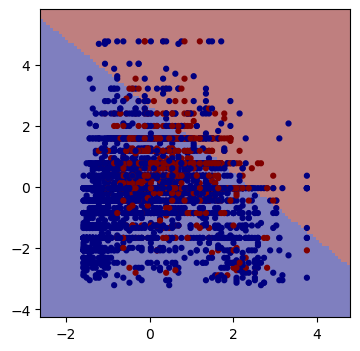

In [180]:
plot_kwargs = {'cmap': 'jet',
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 100}
figure, axes = plt.subplots(1, 1, figsize=(4,4))
DecisionBoundaryDisplay.from_estimator(model2, X_train, ax=axes, **plot_kwargs)
axes.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor=None, s=12, cmap='jet')
plt.show()

SVM

In [ ]:
degrees=[1,2,5,20]
figure,axes = plt.subplots(1,4,figsize=(12,3))

for i,d in enumerate(degrees):
    
# Each item in the pipeline is a pair, (name, transform); the end is (name, learner):
    learner = Pipeline( [('poly',PolynomialFeatures(degree=d)),
                         ('scale',StandardScaler()), 
                         ('logreg',SGDClassifier(loss='log_loss',
                                                 penalty='l2',alpha=1e-20,
                                                 learning_rate='adaptive', eta0=1e-2,
                                                 tol=0.,max_iter=100000,n_iter_no_change=1000))
                        ])

    ### YOUR CODE STARTS HERE
    learner.fit(X_train,y)
    # Fit the model
    DecisionBoundaryDisplay.from_estimator(learner, X, **plot_kwargs, ax=axes[i])
    axes[i].scatter(X_train[:, 0], X_train[:, 1], c=y, edgecolor=None, s=12, cmap='jet')
    axes[i].set_title(f'{d} degree')

## Part 2: race vs income

### Sophisticated decision tree structures

In [7]:
X_label = np.array(X_original)[:20000,8]
X_label

array(['White', 'White', 'White', ..., 'White', 'White', 'White'],
      dtype=object)

In [9]:
encoder = LabelEncoder()
labels = encoder.fit_transform(X_label)
print(labels)

[4 4 4 ... 4 4 4]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labels, y, test_size=0.3, random_state=42)

In [14]:

dt = tree.DecisionTreeClassifier(max_depth=100, criterion='entropy', random_state=42)
dt.fit(X_train, y_train)
train_preds = dt.predict(X_train)
val_preds = dt.predict(X_test)
train_error = np.mean(y_train != train_preds)
val_error = np.mean(y_test != val_preds)
print(f"Training Error Rate: {train_error:.4f}")
print(f"Validation Error Rate: {val_error:.4f}")

Training Error Rate: 0.2001
Validation Error Rate: 0.2470


In [15]:
tree.plot_tree(dt, feature_names=X_label.columns, class_names=['<=50K', '>50K'], filled=True)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'